# **Imports**

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns      


color_pal = sns.color_palette()

plt.style.use('fivethirtyeight')


from sklearn.metrics import mean_squared_error
import xgboost as xgb 


In [43]:
df = pd.read_csv('./PJME_hourly/PJME_hourly.csv')
df

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0


In [44]:
df.tail(5)

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


`The data begins with the date of 2012 and goes from there to the date of January 2018`

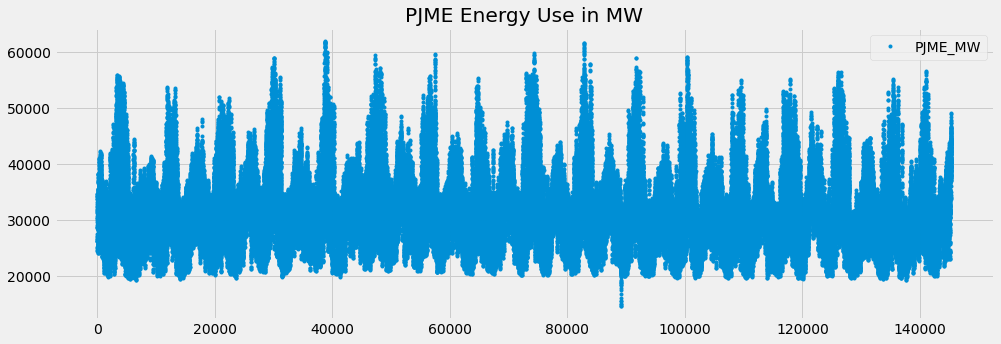

In [45]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

In [46]:
df = df.set_index('Datetime')    
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


The index type is of 'object'. Will have to change to datetime format.

In [47]:
df.index = pd.to_datetime(df.index)

In [48]:
df.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

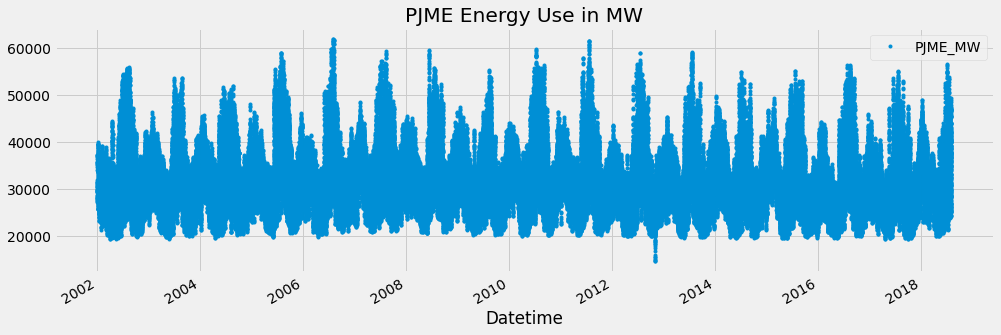

In [49]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

# **Train/Test Split**

In [50]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

###  `Vizualizing the train/test split`

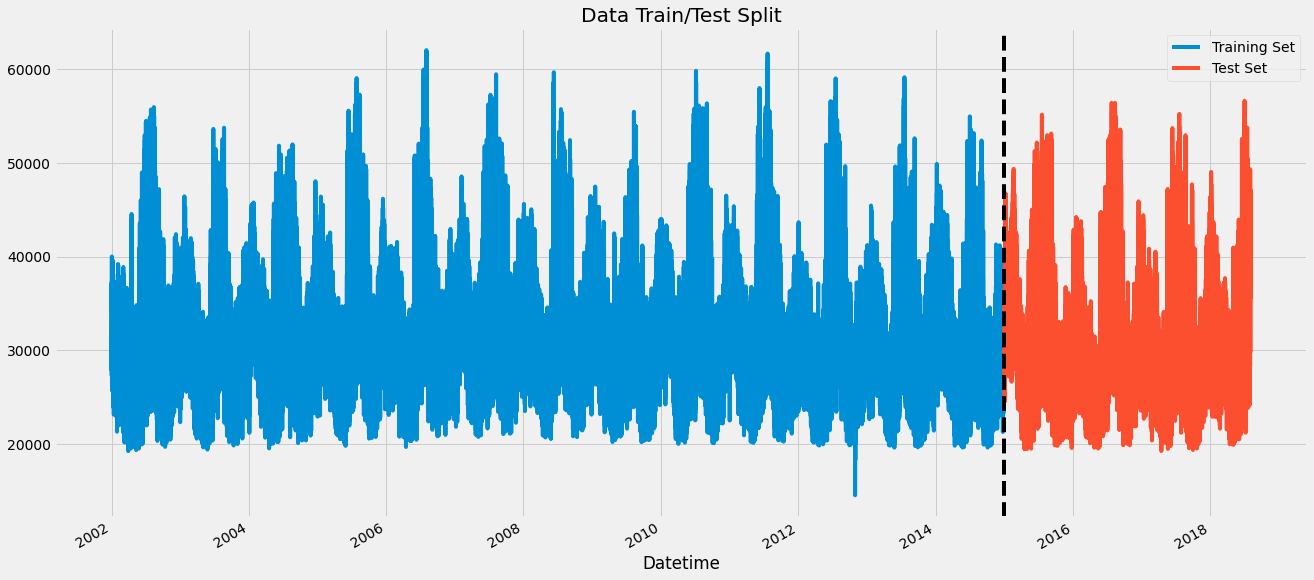

In [51]:
fig, ax = plt.subplots(figsize=(20,10))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

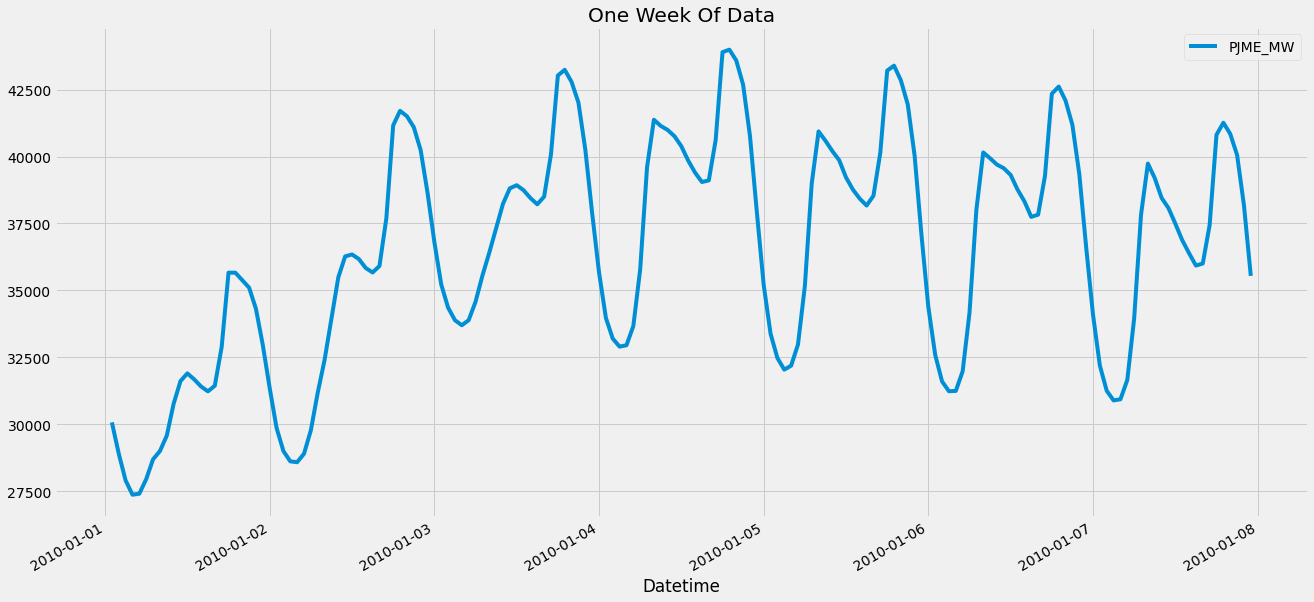

In [52]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize =(20,10), title = 'One Week Of Data')
plt.show()

In [53]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# **Vizualizing the Feature Vs. target features**

### `Vizualizing the usage by hour`

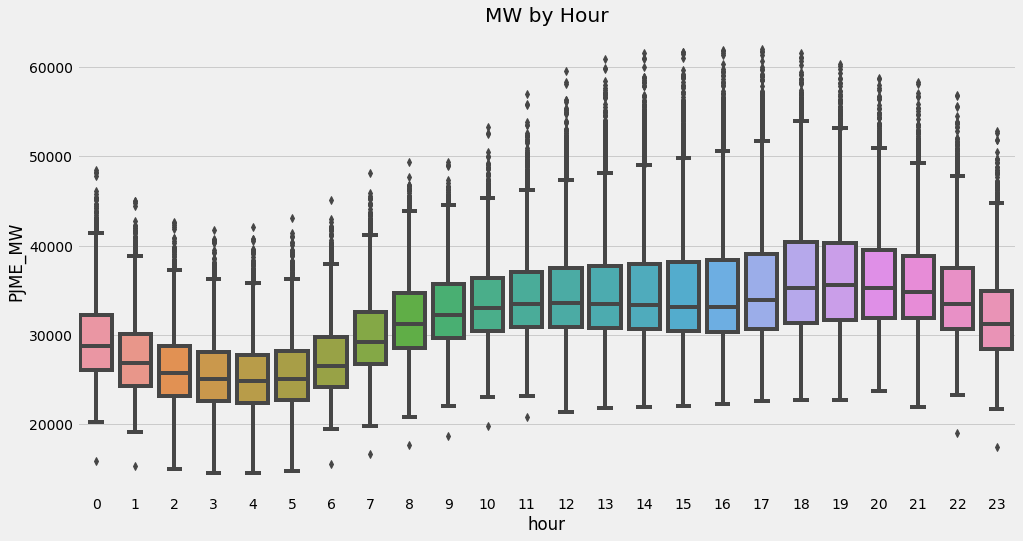

In [54]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

### `Vizualizing the usage by months`

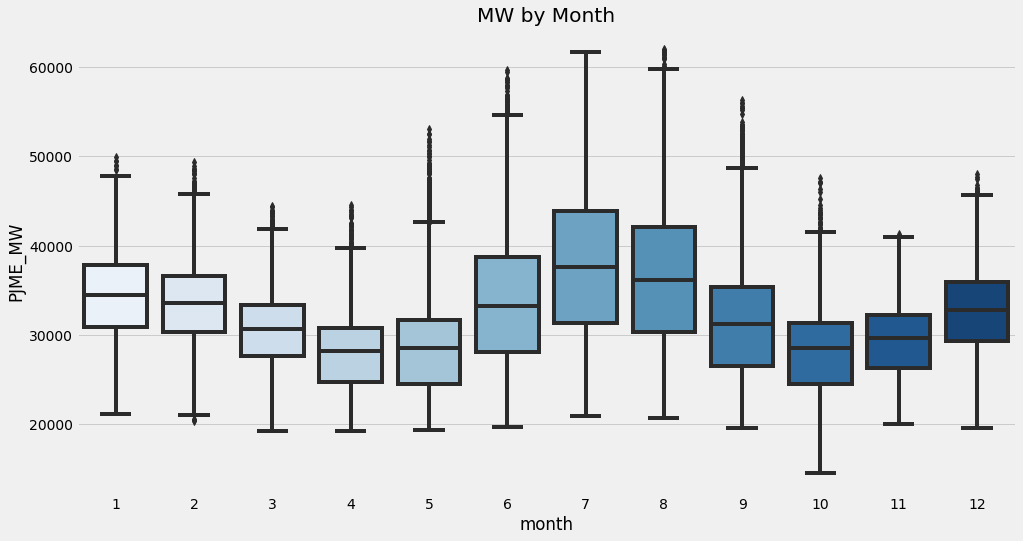

In [55]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

# **Creating the model**

In [56]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear'],
      dtype='object')

In [57]:
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = ['PJME_MW'] 

In [58]:
train.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [59]:
test.head()

,PJME_MW
Datetime,
2015-01-01 00:00:00,32802.0
2015-12-31 01:00:00,24305.0
2015-12-31 02:00:00,23156.0
2015-12-31 03:00:00,22514.0
2015-12-31 04:00:00,22330.0


In [60]:
train = create_features(train)
test = create_features(test) 

X_train = train[FEATURES]
y_train = train[TARGET] 

X_test = test[FEATURES]
y_test = test[TARGET]

In [61]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[20:45:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32605.13860	validation_1-rmse:31657.15907
[100]	validation_0-rmse:12581.21576	validation_1-rmse:11743.75117
[200]	validation_0-rmse:5835.12473	validation_1-rmse:5365.67712
[300]	validation_0-rmse:3915.75572	validation_1-rmse:4020.67027
[400]	validation_0-rmse:3443.16487	validation_1-rmse:3853.40425
[500]	validation_0-rmse:3285.33827	validation_1-rmse:3805.30193
[600]	validation_0-rmse:3201.92939	validation_1-rmse:3772.44905
[700]	validation_0-rmse:3148.14225	validation_1-rmse:3750.91088
[800]	validation_0-rmse:3109.24250	validation_1-rmse:3733.89694
[900]	validation_0-rmse:3079.40078	validation_1-rmse:3725.61208
[999]	validation_0-rmse:3052.73502	validation_1-rmse:3722.92243


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=0, reg_alpha=0, ...)

`weights of each features taken into the model training: `

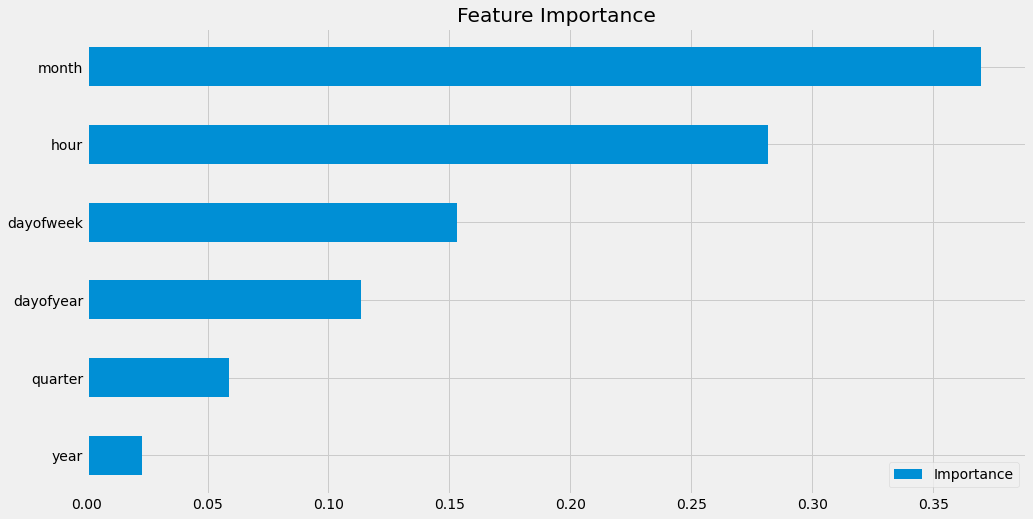

In [62]:
feature = reg.feature_importances_

fig = pd.DataFrame(data=feature, index=reg.feature_names_in_, columns=['Importance'])
fig.sort_values('Importance').plot(kind = 'barh', title='Feature Importance',figsize=(15,8))
plt.show()

In [63]:
test['prediction'] = reg.predict(X_test)
test

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
Datetime,,,,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1,1,1,30527.792969
2015-12-31 01:00:00,24305.0,1,3,4,12,2015,365,31,53,28238.072266
2015-12-31 02:00:00,23156.0,2,3,4,12,2015,365,31,53,27310.228516
2015-12-31 03:00:00,22514.0,3,3,4,12,2015,365,31,53,26884.867188
2015-12-31 04:00:00,22330.0,4,3,4,12,2015,365,31,53,26884.867188
...,...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,1,1,36173.691406
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,1,1,36114.285156
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,1,1,34566.804688


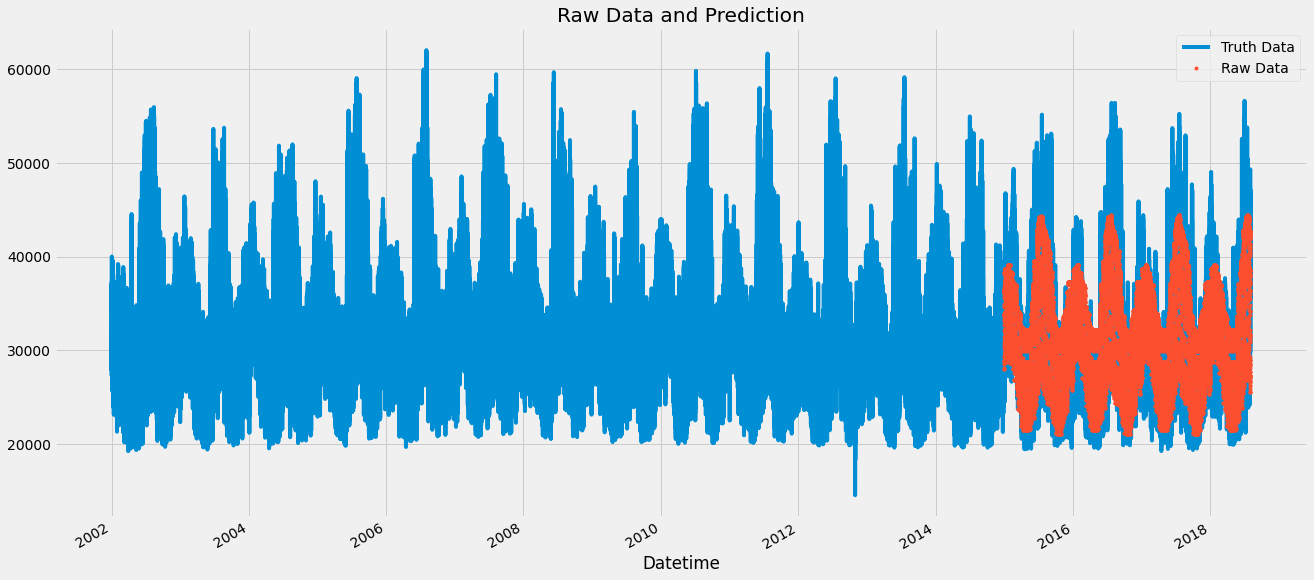

In [64]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(20, 10))
df[['prediction']].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Raw Data'])
ax.set_title('Raw Data and Prediction')
plt.show()

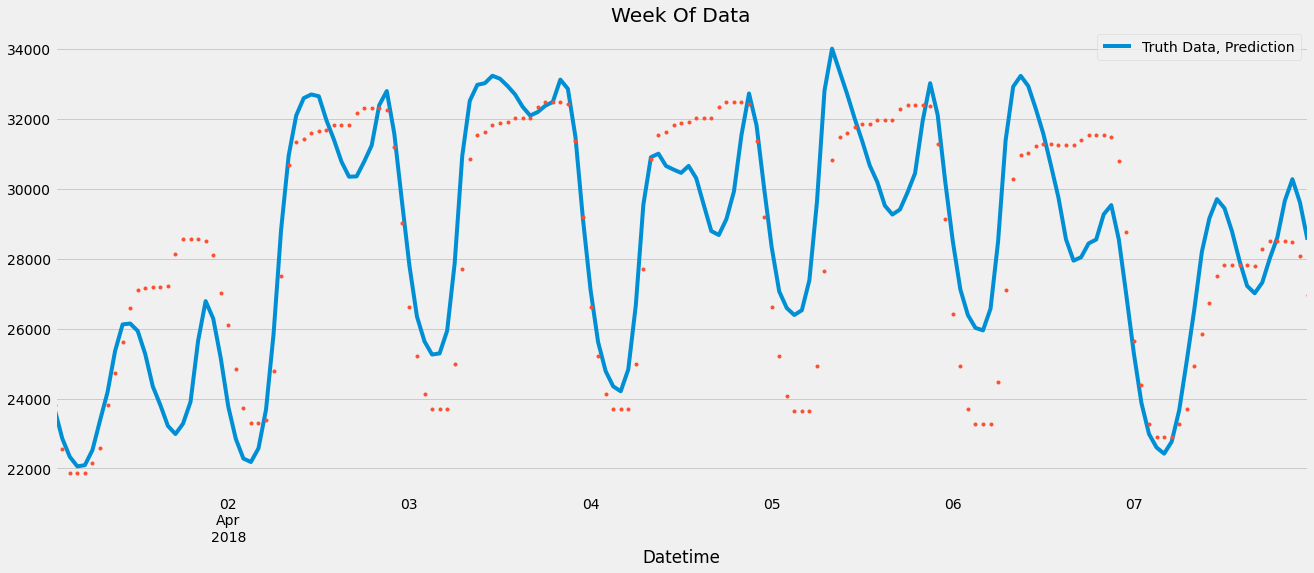

In [65]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(20, 8), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data, Prediction'])
plt.show()


# **Root Mean Square Error**

In [66]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'The root mean squared error is: {score: 0.2f}')

The root mean squared error is:  3721.75


In [67]:
# test['error'] = np.abs(test[TARGET] - test['prediction'])
# test['date'] = test.index.date 
# test.groupby(['date'])['error'].mean().sort_values(ascending = False)  


# **Outlier Analysis and Removal**

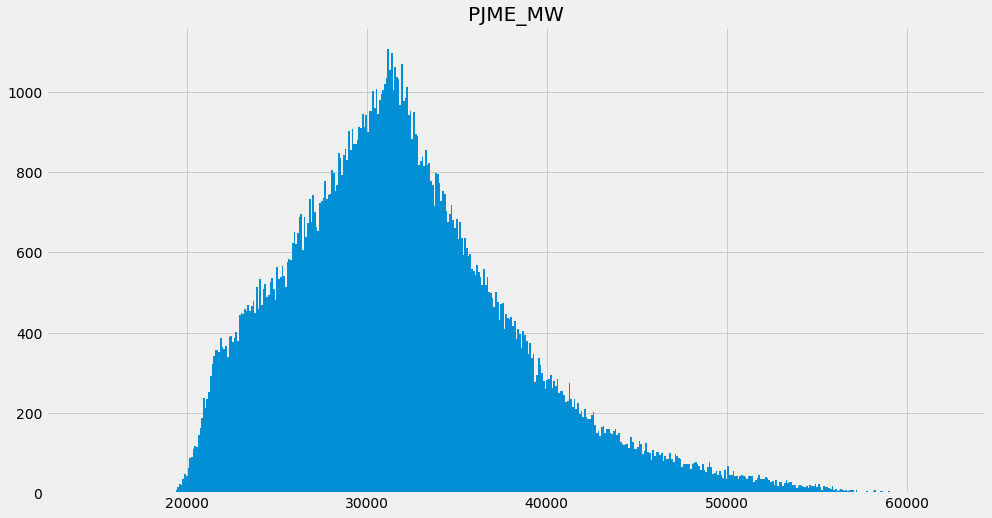

In [68]:
df.hist('PJME_MW', bins= 500 , figsize=(15,8))
plt.show()

`We can see that most of the data points lie between 20,000 to 50,000.`

In [74]:
# df.query('PJME_MW < 19,000')['PJME_MW'].plot(style='.',figsize=(20, 10),color=color_pal[5],title='Outliers')
# plt.show()